In [223]:
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('ggplot')
from matplotlib.font_manager import _rebuild
from pylab import mpl
_rebuild()
mpl.rcParams['font.sans-serif'] = [u'SimHei']
mpl.rcParams['axes.unicode_minus'] = False

In [224]:
# %load ../Import.py
import pandas as pd
import numpy as np
import psycopg2
import matplotlib.pyplot as plt
plt.style.use('ggplot')
pd.set_option('display.float_format', lambda x: '%.5f' % x)

from sklearn import linear_model
import scipy.stats as scs
#import statsmodels.api as sm

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

In [225]:
df = pd.read_csv('df_sku.csv', dtype='str')
df.pop('Unnamed: 0');

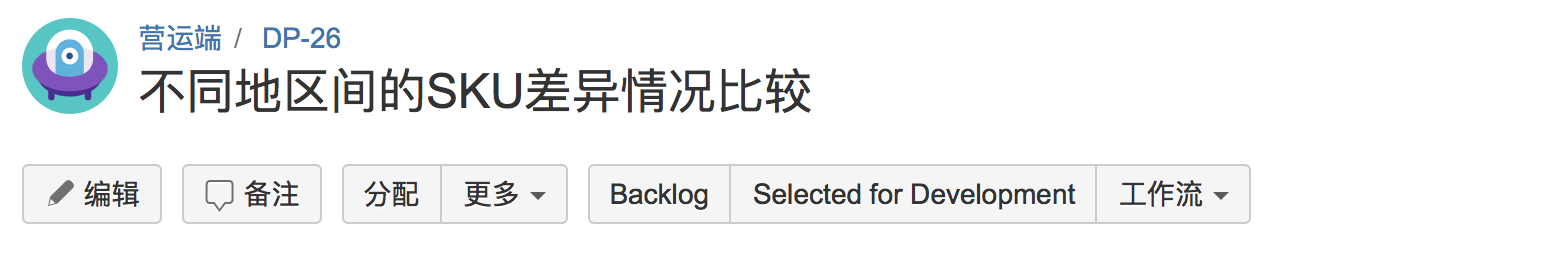

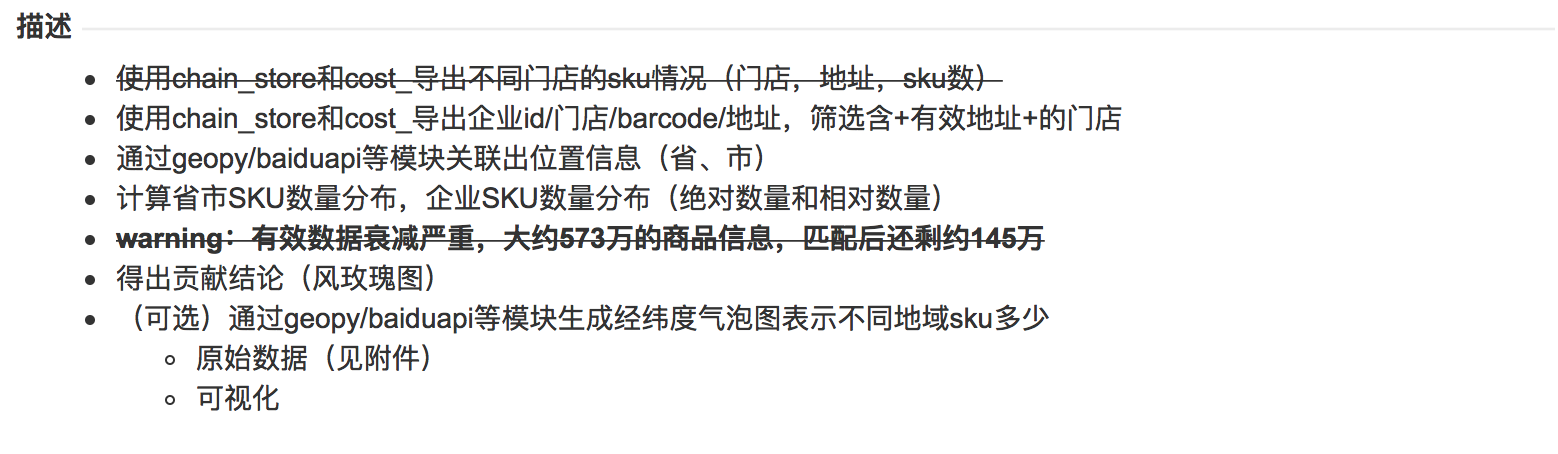

2018-5-17  TODO：
- 重现清洗数据，<u>取固定时间段</u>，验证数据合理，与数据库比对
- 去掉无关列，补充数据验证的threshold，并说明数据有效

2018-5-17  目的：
- 从分布/规模/提供推荐依据
- 从商品/独有/重复推导出可推荐

## 商品规模

- 原始数据

   ** 除57为2016-10-9以后外，其余均为2016-01-01以后的商品数据

In [104]:
df.head()

,area,cmid,province,city,foreign_store_id,barcode
0,华北,1015,北京市,北京市,A037,6922877745508
1,华北,1015,北京市,北京市,A037,6902890230632
2,华北,1015,北京市,北京市,A037,6913231004003
3,华北,1015,北京市,北京市,A037,6901668005731
4,华北,1015,北京市,北京市,A037,4902780046116


- 净总商品数

- 总门店数

In [107]:
print('%s 件'%df.drop_duplicates('barcode').shape[0])

131978 件


In [60]:
total_store = pd.DataFrame(df.drop_duplicates(['cmid', 'foreign_store_id']).groupby(
    ['area', 'cmid', 'province', 'city']).foreign_store_id.count()).sort_values('foreign_store_id', ascending=False)
print('%s 家'%total_store.foreign_store_id.sum())

1818 家


### 按区域

- 城市净总商品数前十名&后十名

In [109]:
scale_city = pd.DataFrame(df.drop_duplicates(['city','barcode'],keep='first').groupby(['city']).barcode.count(
)).sort_values('barcode',ascending=False)
scale_city.T

city,北京市,西安市,福州市,惠州市,廊坊市,东莞市,邢台市,深圳市,呼和浩特市,衡水市,...,延安市,泉州市,揭阳市,沧州市,咸阳市,天津市,天水市,金华市,三亚市,汉中市
barcode,50371,33956,28192,11025,9826,8083,8069,7591,7461,6897,...,3281,3050,2895,2674,2407,1689,1452,1442,1384,1275


- 省级和地区级净总商品数比例

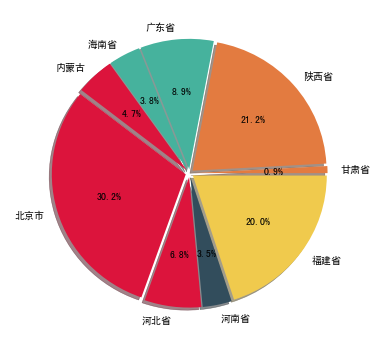

In [110]:
scale_province = df.drop_duplicates(['province', 'barcode'], keep='first')
labels = ['甘肃省','陕西省','广东省','海南省','内蒙古','北京市','河北省','河南省','福建省']
colors = ['#E37B40','#E37B40','#46B29D','#46B29D','crimson','crimson','crimson','#324D5C','#F0CA4D']
scale_province.groupby(['area','province']).count(
).sort_values('area', ascending=False).barcode.plot.pie(autopct='%.1f%%', figsize=(6, 6),shadow=True,labels=labels,colors=colors, explode=(0.03, 0.03, 0.03, 0.03, 0.03,0.03,0.03,0.03,0.03))
plt.axis('off');

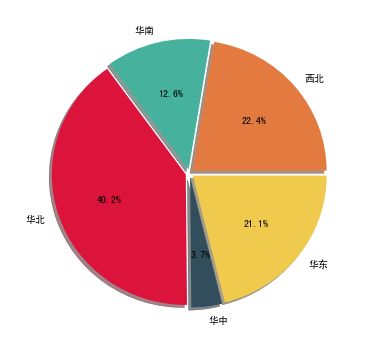

In [111]:
scale_area = df.drop_duplicates(['area', 'barcode'], keep='first')
colors = ['#E37B40','#46B29D','crimson','#324D5C','#F0CA4D']
scale_area.groupby(['area']).count(
).sort_values('area', ascending=False).barcode.plot.pie(autopct='%.1f%%', figsize=(6, 6),shadow=True, colors=colors, explode=(0.03, 0.03, 0.03, 0.03, 0.03))
plt.axis('off');


> - 北方地区与南方地区的商品规模约为6:4，其中北京与福建分别为南北规模最大的省级区域，各自占有半壁江山。（60%-30%、40%-20%）

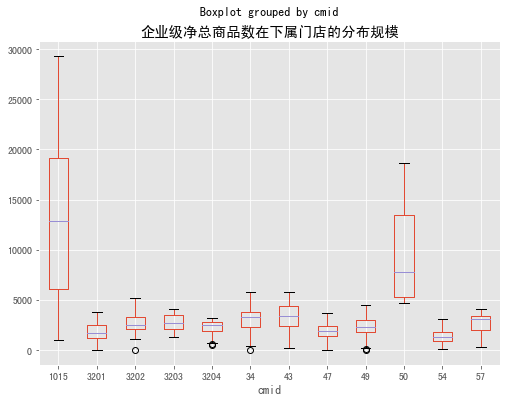

In [168]:
scale_store = pd.DataFrame(df.drop_duplicates(['cmid','foreign_store_id','barcode']).groupby(['cmid','foreign_store_id']).barcode.count())
scale_store.boxplot(figsize=(8,6),column='barcode',by='cmid')
plt.title('企业级净总商品数在下属门店的分布规模');

（参考资料：[请问零售业专家，一个大型超市的商品数通常是多少？](https://www.zhihu.com/question/19617135) ）

> - 从平均水平来看：
    - 超市发-1015是典型的标超类，品数在10000左右；
    - 剩下的是便利店类，品数在3000左右；
    - 六意-50介于他们之间。
- 从数据宽度来看：
    - 超市发-1015半数是标超类，也拥有大卖场和便利店规模各1/4；
    - 六意-50有半数达到标超类级别的门店。

- 企业净总商品数量/门店数量/店均规模

In [61]:
scale_cmid = pd.DataFrame(df.drop_duplicates(['cmid','barcode'],keep='first').groupby([ 'cmid']).barcode.count(
)).sort_values('barcode', ascending=True)
figure_cmid = pd.merge(scale_cmid,total_store.groupby('cmid').sum(),left_index=True,right_index=True).sort_values('barcode',ascending=False)

 <img src="Geo.png" width = "600" height = "400" align=left />

> - 无论业态是小而美还是大而全，做到极致都可以增大整体商品规模
- 坐标系上距离较近的企业，可以作为推荐的依据

## 商品差异

In [135]:
df_uniq = df.drop_duplicates(['cmid', 'barcode'], keep=0)

- 企业独有的商品内部占比

In [213]:
uniq_ratio = pd.DataFrame([df_uniq.groupby(['cmid']).barcode.count(), scale_cmid.barcode],index=['uniq','total']).T.sort_values('uniq',ascending=False)
uniq_ratio['ratio'] = uniq_ratio.uniq/uniq_ratio.total
uniq_ratio['ratio'] = uniq_ratio['ratio'].apply(lambda x:'%.1f%%'%(x*100))
uniq_ratio.T

,3201,50,1015,3202,54,49,3204,57,43,47,3203,34
uniq,12406,10103,8993,4747,2413,1749,1548,1148,994,941,793,701
total,28453,29222,50371,11816,6420,9603,5767,6104,11416,7092,5920,7804
ratio,43.6%,34.6%,17.9%,40.2%,37.6%,18.2%,26.8%,18.8%,8.7%,13.3%,13.4%,9.0%


- 商品被重复销售次数

In [17]:
df_goods = df.pivot_table(values='foreign_store_id',index='barcode',columns='cmid',aggfunc='count').fillna(0)
df_goods = df_goods.applymap(lambda x:1 if x>0 else 0)
df_goods['sum'] = df_goods.apply(lambda x: x.sum(),axis=1)

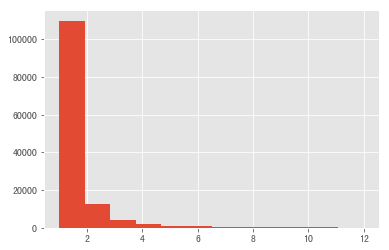

In [80]:
df_goods.iloc[:,-1].hist(bins=12);

In [44]:
print(df_goods['sum'].value_counts())
print('独家销售率：%.1f%%'%(109868*100/df.drop_duplicates('barcode').shape[0]))

1     109868
2      12411
3       4118
4       1985
5       1154
6        787
7        521
8        324
9        268
10       225
11       181
12       135
Name: sum, dtype: int64
独家销售率：83.2%


> 在131978件净总商品中，有26.8%的商品被多家企业销售；只有0.01%是所有企业都共有的，完全不可推荐

- 企业的推荐指数评级
    - 企业在每件商品上的得分是其他未销售此商品的企业数量，即可推荐数量
    - 加总得分求平均可推荐数量，即推荐指数

In [228]:
df_goods.head(10)

cmid,1015,3201,3202,3203,3204,34,43,47,49,50,54,57
barcode,,,,,,,,,,,,
"""6940101900608""",0,0,11,0,0,0,0,0,0,0,0,0
"""697053687092 """,0,0,11,0,0,0,0,0,0,0,0,0
'6949634272169,0,10,10,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,9,0,0,9,9,0,0
00,0,0,0,0,0,0,0,11,0,0,0,0
000,0,10,0,0,10,0,0,0,0,0,0,0
0000000,0,8,8,0,8,0,0,0,8,0,0,0
00000000,0,11,0,0,0,0,0,0,0,0,0,0
000000016,0,0,0,0,0,0,0,0,0,0,0,11


In [44]:
%%time
for index, value in df_goods.iterrows():
    value[value > 0] = 12 - value['sum']
df_goods.loc['total'] = df_goods.apply(lambda x: x.sum(), axis=0)
df_goods_counts = df_goods.applymap(lambda x: np.NaN if x==0 else x)

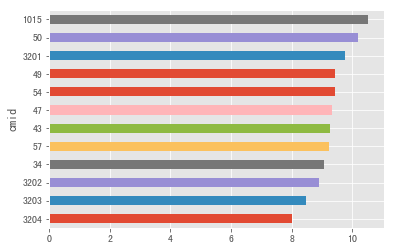

In [215]:
(df_goods.loc['total']/df_goods_counts.count()).sort_values().plot.barh();

> - 没有哪一家的商品被完全包含，最少也可以推荐到其他8家企业
- 对比企业商品独有率和推荐指数，可以发现独家商品多并不代表在推荐商品上就有优势，反而总是那部分有一定重合度的商品的数量多才有助于推荐（3202 v.s. 54）
- 绝对的体量仍然是选择新客户的重要因素之一（1015，50，3201）